<span style="color:#ff8c00; font-size:28px; font-weight:700;">Définir précisément le “Positif” avant de benchmarker notre retrieval RAG</span>

## Pourquoi la définition de “Positif” est le point de départ (et non un détail)
Avant même de discuter de BM25, dense, hybride, reranking ou temporalité, **la première décision structurante** est : *qu’appelle-t-on exactement un “positif” ?*  
Autrement dit : *qu’est-ce que nous considérons comme un “succès” (TP) et donc comme un “échec” (FN) dans notre pipeline ?*

Lors de notre échange d’entretien avec **Mehdi** et **Julien**, plusieurs façons d’aborder le risque des **FN** ont été évoquées :  
- réduire les FN au sens “aucune bonne source dans le top-k” (le LLM ne peut pas citer → risque juridique) ;  
- réduire les FN au sens “pas le bon document” (mauvaise version / mauvaise source canonique) ;  
- réduire les FN au sens “preuves insuffisantes” (il manque une exception/condition essentielle) ;  
- ou encore, au niveau final : “mieux vaut un *no-answer* correct qu’une réponse sans preuve”.

👉 Ces points de vue ne changent pas seulement le discours : **ils changent la vérité terrain, les métriques à implémenter, et la manière d’interpréter les résultats**.  
Une métrique “bonne” avec une mauvaise définition de “positif” peut donner une impression de performance… tout en masquant le risque réel.

---

## Résumé simplifié : 1 définition de “Positif” → des métriques adaptées

### P1 — `passage_hit_k` (chunk/passage-level)
**Positif** ⇔ ≥ 1 passage pertinent dans le top-k  
**Métriques associées** : $Hit@k$ (ou “Success@k”), $MRR$, $nDCG@k$  
**Lecture “risk-first”** : maximiser $Hit@k$ (réduire les FN), puis optimiser l’ordre ($MRR$, $nDCG@k$)

### P2 — `doc_key_hit_k` (doc-level, déduplication)
**Positif** ⇔ ≥ 1 `doc_key` pertinent dans le top-k (après dédup chunks)  
**Métriques associées** : $Hit@k_{docKey}$, $Recall@k_{docKey}$, $MRR_{docKey}$, $nDCG@k_{docKey}$  
**Intérêt** : éviter de “sur-noter” un run qui remonte surtout beaucoup de chunks d’un même document

### P3 — `evidence_coverage_k` (coverage d’un set attendu)
**Positif** ⇔ couverture suffisante d’un ensemble minimal de preuves attendues (seuil $\tau$ possible)  
**Métriques associées** : $Coverage@k$, $Set\text{-}Recall@k$, $Jaccard@k$  
**Intérêt** : refléter un besoin juridique “article + exception + conditions”, et pas seulement “au moins un extrait”

### P4 — `end_to_end` (résultat final + citations / no-answer)
**Positif** ⇔ réponse correcte + citations correctes, **ou** no-answer correct  
**Métriques associées** : $Acc_{NA}$, $Prec_{cit}$, $Rec_{cit}$, $F1_{cit}$ (et $EM/F1$ réponse si gold disponible)  
**Intérêt** : mesurer le comportement réel du système complet (retrieval → rerank → génération/no-answer)

---

## Conclusion — valider la mathématique et l’interprétation n’est pas optionnel
Ce notebook sert donc à **poser un cadre d’évaluation rigoureux** :  
1) expliciter la définition de “Positif” (P1→P4),  
2) implémenter les métriques cohérentes avec cette définition,  
3) vérifier la **mathématique** (formules, hypothèses, bornes, agrégations) et surtout l’**interprétation**.

En juridique, **se tromper à ce niveau n’est pas envisageable** : une confusion sur “positif”, “FN”, ou sur la signification d’un $Recall@k$ / $Hit@k$ peut conduire à optimiser la mauvaise cible et à sous-estimer le risque produit.


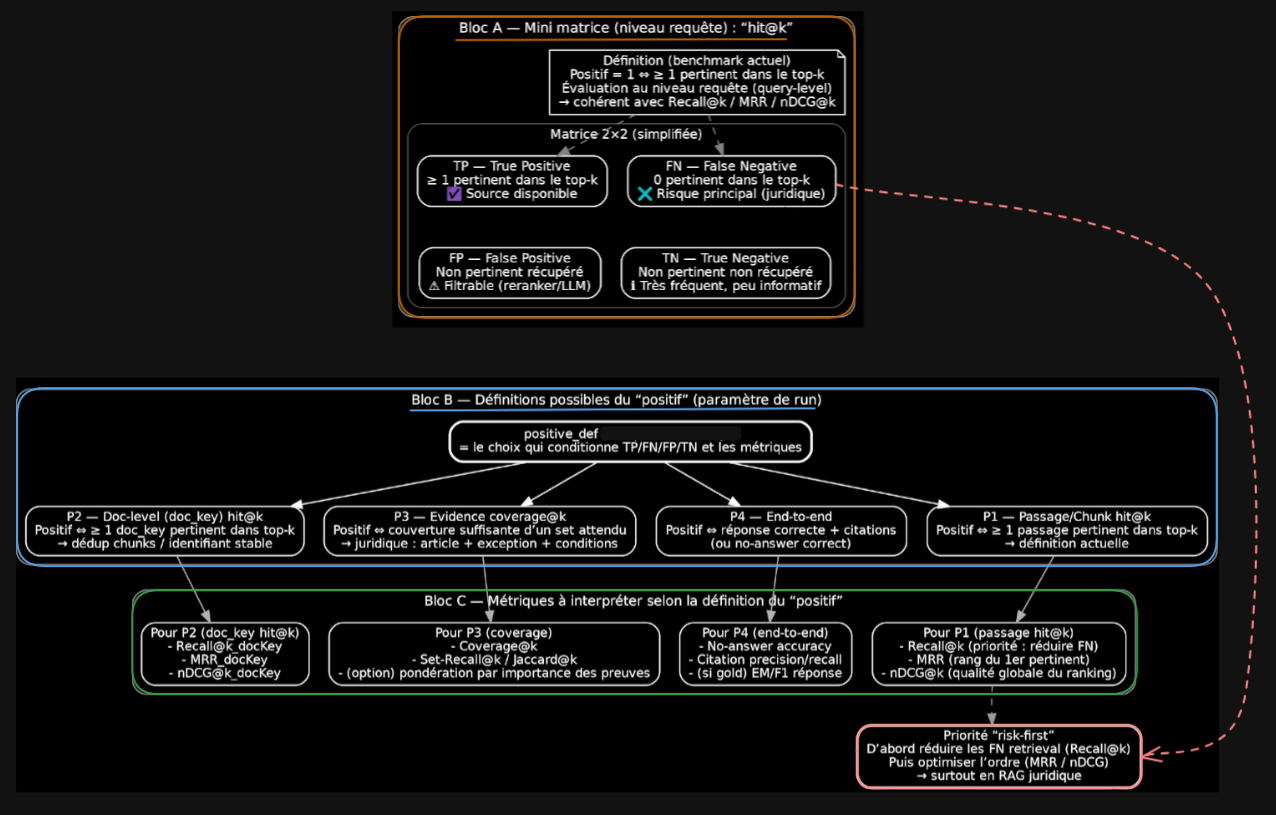

## Clarifications  — Définition du “positif” et interprétation des métriques (Bloc A / Bloc B / Recall@k)

### Bloc A — “Positif = 1 ⇔ ≥ 1 pertinent dans le top-k” : cela veut dire quoi ?
Il faut distinguer **(i) la variable par requête** et **(ii) le comptage sur l’ensemble du benchmark** :

- **Par requête (query-level)**, le “positif” est **binaire** :  
  - succès : au moins 1 pertinent dans le top-k → valeur **1**  
  - échec : aucun pertinent dans le top-k → valeur **0**  
  Même si 3 documents pertinents apparaissent dans le top-k, cela reste **1** (succès).

- **Sur l’ensemble des requêtes**, on peut compter :  
  - N_{pos} = nombre de requêtes avec succès (hit@k = 1)  
  - N_{FN} = nombre de requêtes en échec (hit@k = 0)  

👉 Donc : oui, il existe “$N$ positifs” au niveau dataset, mais **chaque requête** ne produit qu’un **0/1**.

---

### Bloc A — “hit@k” : nom approprié ? métrique existante ?
Le terme **Hit@k** est **approprié** et très courant sous des noms voisins :
- **Hit Rate@k**, **Success@k**, **Hit@k**

Attention : dans le monde RAG, certain·e·s utilisent parfois “Recall@k” pour désigner ce succès binaire, 
mais cela peut être **ambigu** vs le recall IR classique.

👉 Pour éviter toute ambiguïté, le meilleur libellé est : **Hit@k (query-level)** ou **Success@k**.

---

### Bloc B — Différences entre les 4 définitions de “positif” (positive_def)

### 1) `passage_hit_k` vs `doc_key_hit_k` (la vraie différence)
Ici, la différence ne se limite pas à “chunk vs doc_id” : elle concerne surtout **le niveau d’agrégation** 
et la **déduplication**.

- **`passage_hit_k` (chunk/passage-level)**  
  Positif si **au moins un chunk** (passage) pertinent apparaît dans le top-k.  
  → mesure la capacité brute du retriever à ramener **un passage exploitable**.

- **`doc_key_hit_k` (doc-level, identifiant stable)**  
  Positif si **au moins un `doc_key` pertinent** apparaît dans le top-k **après déduplication**.  
  Concrètement : si 8 chunks du même document remontent, cela ne compte que pour **1** document.  
  → évite de “sur-noter” un run qui remonte surtout **plein de chunks du même doc**, 
et se rapproche du signal “ai-je retrouvé la bonne source (document) ?”.

> En juridique, `doc_key_hit_k` est souvent plus proche de 
“ai-je retrouvé le bon article / la bonne décision” que `passage_hit_k`.

---

### 2) `evidence_coverage_k` (coverage) — définition explicite
Ici, “pertinent” n’est plus un seul document : c’est un **ensemble minimal de preuves attendues**.

- Exemple : répondre correctement nécessite **(A) l’article principal + (B) une exception + (C) des conditions**.  
- Positif si le top-k **couvre suffisamment** cet ensemble attendu (100% ou un seuil $\tau$).

👉 Cela mesure : “est-ce que le retriever ramène toutes les pièces nécessaires pour argumenter juridiquement ?”

---

### 3) `end_to_end` — définition explicite
Ici, “positif” = **résultat utilisateur final** :
- soit **réponse correcte + citations correctes**,  
- soit **no-answer correct** (abstention) quand il ne faut pas répondre faute de sources.

👉 Cela mesure : “le système complet (retrieval → rerank → génération/no-answer) se comporte-t-il correctement ?”

---

## Recall@k et FN — relation, intervalle, interprétation
### Intervalle
En pratique : $Recall@k \in [0,1]$.

### “Plus Recall@k est grand, plus on réduit les FN” : vrai dans quel cadre ?
- Si on utilise **Hit@k (query-level)** (succès si ≥1 pertinent dans le top-k), alors :
  - $Hit@k = 1 - FN\_rate@k$  
  Donc **quand Hit@k augmente, le taux de FN diminue mécaniquement**.

- Si on utilise le **Recall IR classique** (plusieurs documents pertinents possibles), alors :
  - Recall@k mesure la **fraction** des pertinents récupérés parmi **tous** les pertinents.  
  C’est plus fin, mais ce n’est pas exactement “FN ou pas FN” au sens “aucun pertinent”.

👉 Dans notre logique “risk-first = éviter de rater la source”, la métrique la plus alignée est **Hit@k (query-level)** 
(souvent appelée “Recall@k” en RAG, mais il vaut mieux la nommer Hit@k pour éviter la confusion).

---

## Avertissement / micro-amélioration visuelle (recommandée)
Pour supprimer toute ambiguïté dans le schéma :
- dans le **Bloc A**, remplacer “hit@k” par **“Hit@k (query-level)”** ;
- dans le **Bloc C**, écrire **Hit@k** (au lieu de Recall@k) si on vise explicitement l’interprétation 
“réduction des FN = succès/échec par requête”.

Cela rend la lecture immédiatement évidente pour un jury : “on minimise les FN retrieval (Hit@k), 
puis on optimise l’ordre (MRR / nDCG)”.




### Notations (pour une requête $q$)
- Le retriever retourne une liste ordonnée $R_q^k = (d_1, d_2, \dots, d_k)$.
- Ensemble des documents pertinents (qrels) : $Rel_q$ (taille $|Rel_q|$).
- Pertinence binaire : $rel(d) \in \{0,1\}$ (ou pertinence graduée $rel(d)\in\{0,1,2,\dots\}$).
- Indicateur : $\mathbb{1}[\cdot]$ vaut 1 si la condition est vraie, sinon 0.

---

## 1) "Hit@k" / "Success@k" (niveau requête, binaire)
Succès si au moins un pertinent est présent dans le top-$k$ :
$
Hit@k(q) = \mathbb{1}\left[\sum_{i=1}^{k} rel(d_i) \ge 1\right]
$

Moyenne sur l’ensemble des requêtes $Q$ :
$
Hit@k = \frac{1}{|Q|}\sum_{q\in Q} Hit@k(q)
$

Taux de faux négatifs (au sens "aucun pertinent dans le top-k") :
$
FN\_rate@k = 1 - Hit@k
$

---

## 2) Recall@k (IR classique, quand plusieurs pertinents existent)
Recall par requête :
$
Recall@k(q)=\frac{\sum_{i=1}^{k} rel(d_i)}{|Rel_q|}
$

Moyenne sur les requêtes :
$
Recall@k=\frac{1}{|Q|}\sum_{q\in Q} Recall@k(q)
$

---

## 3) MRR (Mean Reciprocal Rank)
Rang du premier document pertinent :
$
rank_q = \min \{\, i \in \{1,\dots,k\} \mid rel(d_i)=1 \,\}
$
Si aucun pertinent dans le top-$k$, on prend $1/rank_q = 0$.

MRR :
$
MRR=\frac{1}{|Q|}\sum_{q\in Q}\frac{1}{rank_q}
$

---

## 4) DCG@k et nDCG@k (pertinence graduée recommandée)
DCG@k :
$
DCG@k(q)=\sum_{i=1}^{k}\frac{2^{rel(d_i)}-1}{\log_2(i+1)}
$

IDCG@k (DCG idéal) : même formule mais avec les documents triés par pertinence décroissante.

nDCG@k :
$
nDCG@k(q)=\frac{DCG@k(q)}{IDCG@k(q)}
$

Moyenne :
$
nDCG@k=\frac{1}{|Q|}\sum_{q\in Q} nDCG@k(q)
$

---

## 5) Doc-level (doc_key) : déduplication avant métriques
Soit $key(d)$ le doc_key. On définit l’ensemble des doc_keys récupérés dans le top-$k$ :
$
K_q^k = \{\, key(d_i)\mid i=1,\dots,k \,\}
$
et l’ensemble des doc_keys pertinents attendus :
$
KRel_q = \{\, key(d)\mid d \in Rel_q \,\}
$

DocKey Hit@k :
$
Hit@k_{docKey}(q)=\mathbb{1}\left[\, |K_q^k \cap KRel_q| \ge 1 \,\right]
$

(De même, on peut définir $Recall@k_{docKey}(q)=\frac{|K_q^k \cap KRel_q|}{|KRel_q|}$.)

---

## 6) Evidence coverage@k (coverage sur un set attendu)
Ensemble de preuves attendues (doc_keys) : $E_q$.
Ensemble de doc_keys récupérés : $K_q^k$.

Coverage@k :
$
Coverage@k(q)=\frac{|E_q \cap K_q^k|}{|E_q|}
$

(Option seuil) Positif si couverture suffisante :
$
Positif_{coverage}(q)=\mathbb{1}[Coverage@k(q)\ge \tau]
$

Jaccard@k (option utile) :
$
Jaccard@k(q)=\frac{|E_q \cap K_q^k|}{|E_q \cup K_q^k|}
$

---

## 7) End-to-end : no-answer + citations (exemples de métriques)
No-answer accuracy (gold $NA_q \in \{0,1\}$, prédiction $\widehat{NA}_q$) :
$
Acc_{NA}=\frac{1}{|Q|}\sum_{q\in Q}\mathbb{1}[\widehat{NA}_q=NA_q]
$

Citations : ensemble cité prédit $C_q$ vs ensemble attendu $E_q$ (ou $KRel_q$ selon la vérité terrain)

Precision citations :
$
Prec_{cit}(q)=\frac{|C_q \cap E_q|}{|C_q|}
$

Recall citations :
$
Rec_{cit}(q)=\frac{|C_q \cap E_q|}{|E_q|}
$

(F1 citations) :
$
F1_{cit}(q)=\frac{2\,Prec_{cit}(q)\,Rec_{cit}(q)}{Prec_{cit}(q)+Rec_{cit}(q)}
$

